In [255]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [256]:
CLOSE = "Close_BTC"

seed = randint(0, 1000000)
seed = 718099
print(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

718099


In [257]:
file_path = '../data/federalfinancegestion/Rennes_DataChallenge2024_Cryptomarkets_dataset.xlsx'
data = pd.read_excel(file_path)

# Remove all string (object type) columns from the dataset
data_numeric = data.select_dtypes(exclude=['object'])

# Finding the column that closely matches "Close_BTC" in the numeric dataset
close_btc_column_numeric = [col for col in data_numeric.columns if "Close_BTC" in col]

close_btc_column_numeric = close_btc_column_numeric[0]
# Calculate the correlation of all columns with Close_BTC in the numeric dataset
correlation_with_close_btc_numeric = data_numeric.corr()[close_btc_column_numeric].sort_values(ascending=False)

# Extract the top 10 most correlated feature names
top_feature = correlation_with_close_btc_numeric.head(10).index.tolist()
include = top_feature

In [258]:
# Load data
dataset_pickle = '../data/federalfinancegestion/dataset.pkl'
df = pd.read_pickle(dataset_pickle)
df.fillna(0, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

start_date_training = pd.to_datetime('2017-08-01')
end_date_training = pd.to_datetime('2022-08-31')
start_date_testing = pd.to_datetime('2022-09-01')
end_date_testing = pd.to_datetime('2023-04-30')

In [259]:
train_df = df.loc[start_date_training:end_date_training]
test_df = df.loc[start_date_testing:end_date_testing]

In [260]:
# Calculating the logarithmic difference of 'Close'
df['Close_Log'] = np.log(df[CLOSE])  # First, compute the log of 'Close'
df['Log_Diff_Close'] = df['Close_Log'].diff().fillna(0)  # Then compute the difference and handle NaN

In [261]:
# Include features
train = train_df[include].values
test = test_df[include].values

In [262]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [263]:
# # # SDAE
input_layer = Input(shape=(len(include),))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(include), activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(train_scaled, train_scaled, epochs=150, batch_size=32, shuffle=True, validation_split=0.2)

# Get the encoded representation of the data
encoded_features = autoencoder.predict(train_scaled)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of days used to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape inputs for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(include)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(include)))

Epoch 1/150
33/33 [==============================] - 1s 5ms/step - loss: 0.1393 - val_loss: 0.0533
Epoch 2/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0652
Epoch 3/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0183
Epoch 4/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0163
Epoch 5/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0148
Epoch 6/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0151
Epoch 7/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0157
Epoch 8/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0167
Epoch 9/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0151
Epoch 10/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0145
Epoch 11/

In [264]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(include))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 5, 50)             12200     
                                                                 
 lstm_33 (LSTM)              (None, 50)                20200     
                                                                 
 dense_140 (Dense)           (None, 25)                1275      
                                                                 
 dense_141 (Dense)           (None, 1)                 26        
                                                                 
Total params: 33701 (131.64 KB)
Trainable params: 33701 (131.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [265]:
model.fit(X_train, y_train, batch_size=64, epochs=150)

Epoch 1/150
21/21 [==============================] - 3s 4ms/step - loss: 0.0383
Epoch 2/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 3/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 4/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 5/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 6/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 7/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 9/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/150
21/21 [==============================] - 0s 4ms/step - loss: 9.8528e-04
Epoch 12/150
21/21 [==============================] - 0s 4ms/step - loss: 9.7830e-04
Epoch 13/150
21/21 [=========

In [ ]:
# Predict values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(include)-1))), axis=1))[:, 0]

# Slice the actual prices to align with the predictions
actual_prices_aligned = df.loc[start_date_testing:end_date_testing, CLOSE][-len(predictions):]
predictions = pd.DataFrame(predictions, index=actual_prices_aligned.index, columns=['Predicted_Close'])

# Convert actual_prices_aligned to a DataFrame
actual_prices_aligned_df = pd.DataFrame(actual_prices_aligned, columns=[CLOSE])

# Calculating the logarithm of predictions and then the logarithmic difference
actual_prices_aligned_df['Predicted_Close'] = predictions
actual_prices_aligned_df['Predicted_Close'] = np.log(actual_prices_aligned_df['Predicted_Close'])
log_diff_predicted = actual_prices_aligned_df['Predicted_Close'].diff().fillna(0)
log_diff_actual = pd.DataFrame(df["Log_Diff_Close"], index=actual_prices_aligned.index, columns=['Log_Diff_Close'])

5/5 [==============================] - 1s 2ms/step


In [ ]:
money = 10000
money_buy_and_hold = 10000
money_evolution = []
money_evolution_buy_and_hold = []
for i in range(len(log_diff_predicted)):
    money_buy_and_hold = money_buy_and_hold * (1 + log_diff_actual.iloc[i][0])
    money_evolution_buy_and_hold.append(money_buy_and_hold)
    if log_diff_predicted[i] > 0:
        money = money * (1 + log_diff_actual.iloc[i][0])
    else:
        money = money * (1 - log_diff_actual.iloc[i][0])
    money_evolution.append(money)


/tmp/ipykernel_71925/3598392310.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if log_diff_predicted[i] > 0:


In [ ]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(actual_prices_aligned, predictions))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAE
mae = mean_absolute_error(actual_prices_aligned, predictions)
print('Mean Absolute Error (MAE):', mae)

# Calculate RMSE Log diff
rmse = math.sqrt(mean_squared_error(log_diff_actual, log_diff_predicted))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAE Log diff
mae = mean_absolute_error(log_diff_actual, log_diff_predicted)
print('Mean Absolute Error (MAE):', mae)

Root Mean Squared Error (RMSE): 997.8826765964923
Mean Absolute Error (MAE): 694.9149689527551
Root Mean Squared Error (RMSE): 0.048240133909565226
Mean Absolute Error (MAE): 0.03366577152226405


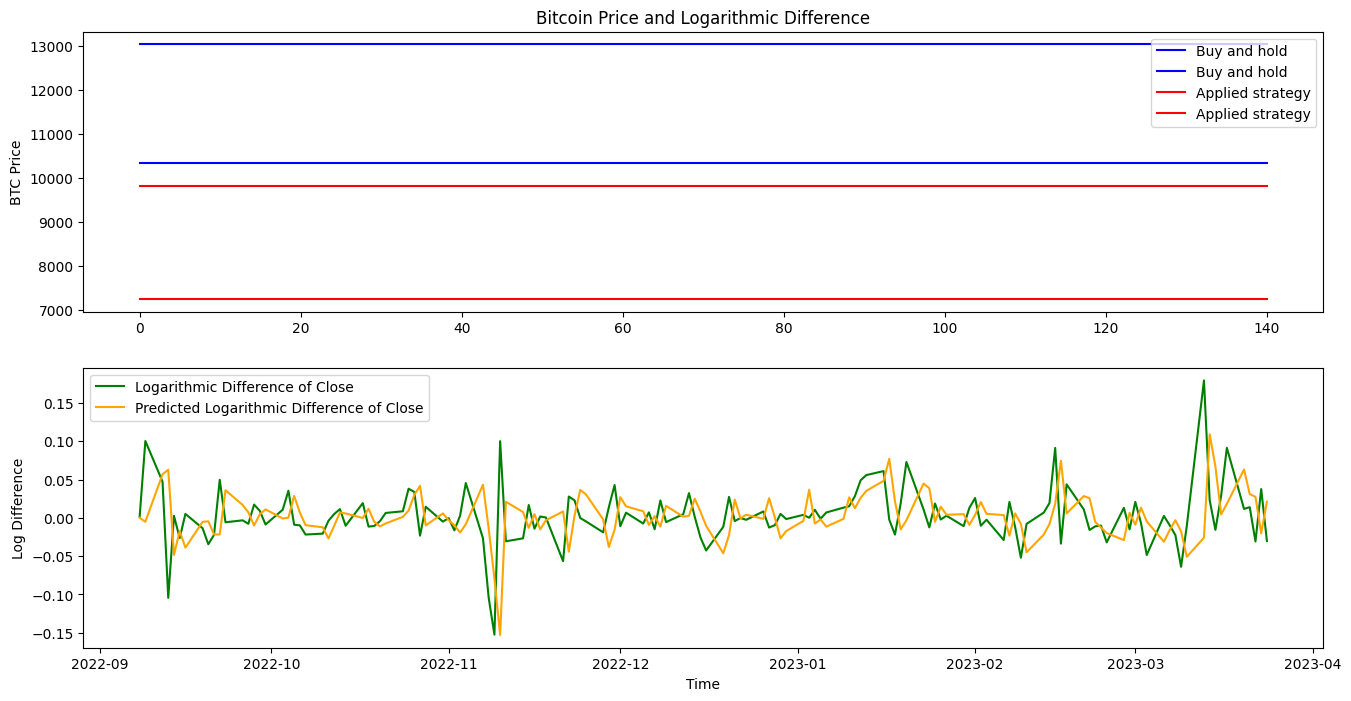

In [ ]:
# Existing plot for 'Close' prices
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)  # First subplot in a 2x1 grid
plt.plot(money_evolution_buy_and_hold, label='Buy and hold', color='blue')
plt.plot(money_evolution, label='Applied strategy', color='red')
plt.title('Bitcoin Price and Logarithmic Difference')
plt.ylabel('BTC Price')
plt.legend()

# New plot for 'Log_Diff_Close'
plt.subplot(2, 1, 2)  # Second subplot in a 2x1 grid
plt.plot(log_diff_actual, label='Logarithmic Difference of Close', color='blue')
plt.plot(log_diff_predicted, label='Predicted Logarithmic Difference of Close', color='red')
plt.xlabel('Time')
plt.ylabel('Log Difference')
plt.legend()

plt.show()